# HR Diagram

In this notebook we'll show you how to make an HR diagram of nearby field stars and a cluster, and use this to determine their relative distances.

You don't have to cut and paste code - if you clone this git repository `https://github.com/benjaminpope/ladder`, these examples will be available under `docs/notebooks`.

First, we'll load all the Python packages we need.

In [1]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import os

from astropy.timeseries import LombScargle
from astropy.table import Table

# configure notebook for plotting
%pylab inline --no-import-all 
mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color'] # allows access to colours
# subsequent lines default plot settings
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 

import warnings
warnings.filterwarnings('ignore')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\neha\AppData\Local\Temp\ipykernel_10152\3037685288.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme


## Load some data

Let's pick a data directory from files I prepared earlier. These were from an earlier run of the universe-making code and don't belong to any group in this project!

Here, `ddir` should be the data directory for the camera where your stars are. The `..` means the directory above the one you are currently working in - it is important that this path points to where **your** data live, or else the code won't know where to look!

In [2]:
ddir = 'universe_8/Top/' # local copy of some data formatted like yours will be


In [4]:
stars = Table.read(ddir+'Star_Data.csv',format='ascii') 

Where do they lie on the sky? In a nice cluster! 

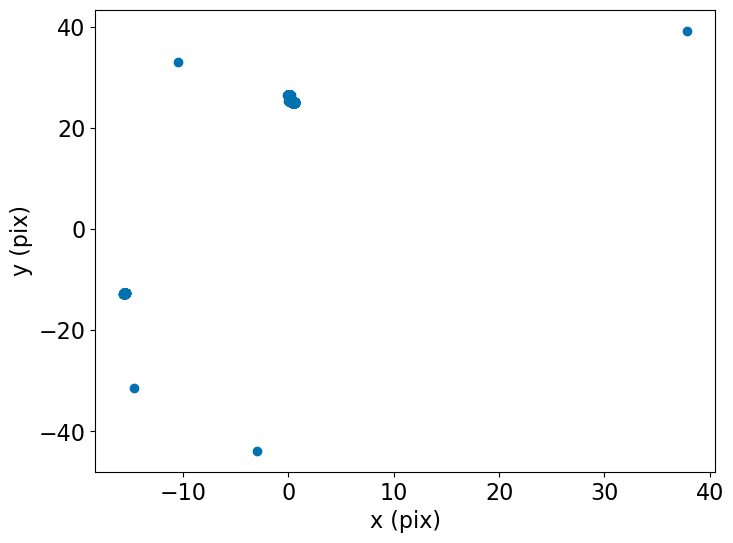

In [6]:
plt.scatter(stars['X'],stars['Y'])
plt.xlabel('x (pix)')
plt.ylabel('y (pix)');

Let's make an HR diagram. One thing to keep in mind is that our convention of using magnitudes is just to match our modern scale to the Ancient Greeks - in your fantasy universe, you can use whatever units you like (but I recommend that they be logarithmic!). This is an important note - lots of students get hung up on the -2.5 and the solar luminosity, but these are just conventions in our world that aren't important for the physics.

So let's have a simple log scale for magnitude here.

In [8]:
m0, m1, m2 = (np.log10(stars['BlueF']), 
              np.log10(stars['GreenF']), 
              np.log10(stars['RedF'])) 
colour = m2-m0

Text(0.5, 0, 'Log Flux 2 - Log Flux 0')

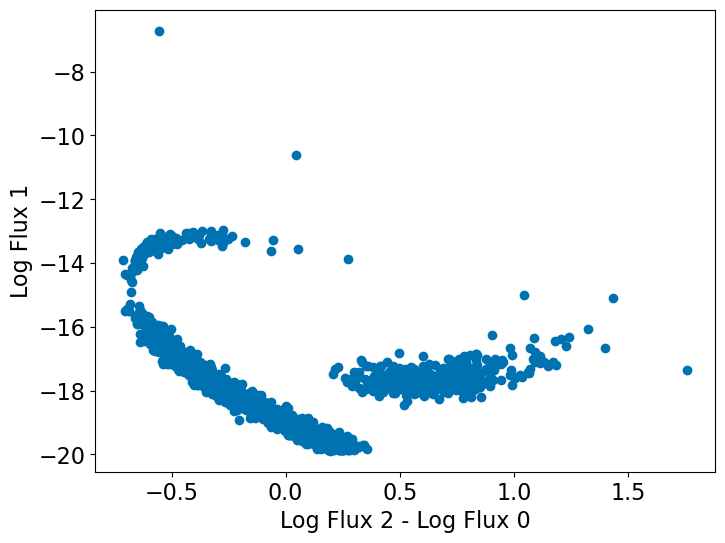

In [9]:
s = plt.scatter(colour,m1)
plt.ylabel('Log Flux 1')
plt.xlabel('Log Flux 2 - Log Flux 0')

Great! We see a main sequence and a giant branch. Let's look at the parallaxes and see if we can get an absolute distance...

In [11]:
print('Parallaxes: mean %.3f, sd %.3f' % (np.mean(stars['Parallax']),np.std(stars['Parallax'])))

Parallaxes: mean 0.001, sd 0.017


Oh dear. Look at those parallaxes - tiny, some are even negative (this is just noise, and happens in real data!). Useless for an absolute distance determination! 

## Nearby stars as benchmarks

We'll have to find out the distance to this cluster by fitting an HR diagram. Let's look at all the nearby stars and see if we can get something nice. 

We are going to make a list of every single `points.txt` file of stars in every camera. 

We use `glob` for this, which is a Python package for searching for filenames, and in this `*` is a 'wildcard' that means match *anything* here that otherwise fits the format - so this means search for `Down`, `Up`, and so forth, and `A01`, `B05` etc for the second `*`. 

In [12]:
import glob # this package lets you search for filenames
import os

all_points = glob.glob('universe_8/*/Star_Data.csv')

Text(0.5, 0, 'Log Flux 2 - Log Flux 0')

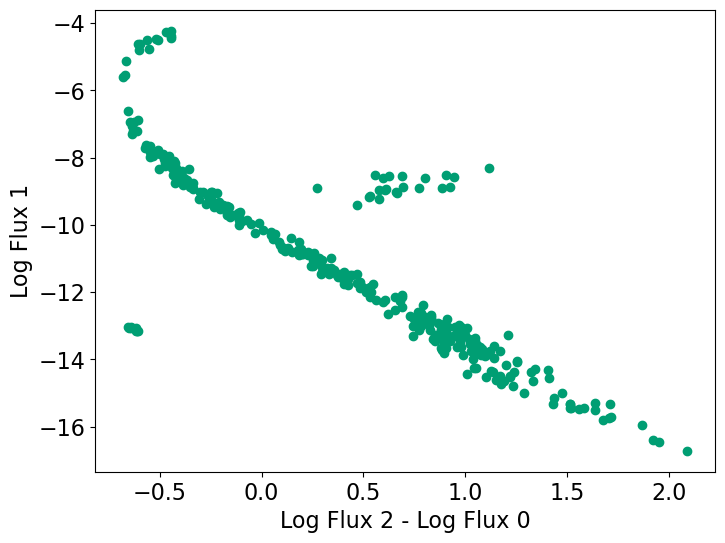

In [15]:
fig, ax1 = plt.subplots(1,1)
for j, point in enumerate(all_points):
    try:
        this = Table.read(point,format='ascii')
        
        thispar = this['Parallax']
        thism0, thism1, thism2 = (np.log10(this['BlueF']), 
                                  np.log10(this['GreenF']), 
                                  np.log10(this['RedF']))
        thiscolour = thism2-thism0
        dist = 1/thispar
        abs_mag = thism1 + 2*np.log10(dist) 
        mm = thispar>0.05 # only pick the ones with good signal-to-noise
        
        ax1.scatter(thiscolour[mm],abs_mag[mm],color=colours[1])
    except:
        pass

plt.ylabel('Log Flux 1')
plt.xlabel('Log Flux 2 - Log Flux 0')

Cool! There are tons of stars in here! 

## Distance Estimation

Let's estimate the distance to this cluster. Remember the inverse square law - the brightness you see is proportional to 

```
(brightness at distance d1)*(d1**2 / d2 **2)
```

What we want to do is *standardize* everything to how bright it would be at a distance of, for the sake of argument, 1 parsec. (In real research, for no particular reason, people usually use 10 parsecs for absolute magnitudes, but for simplicity we will use 1). 

If we're working in log units, `log(1/d**2) = -2*log(d)`, so this means that our standardized log flux is 

```
abs_mag = observed_mag + 2*log(dist) 
```

Now let's plot them on the same axes.

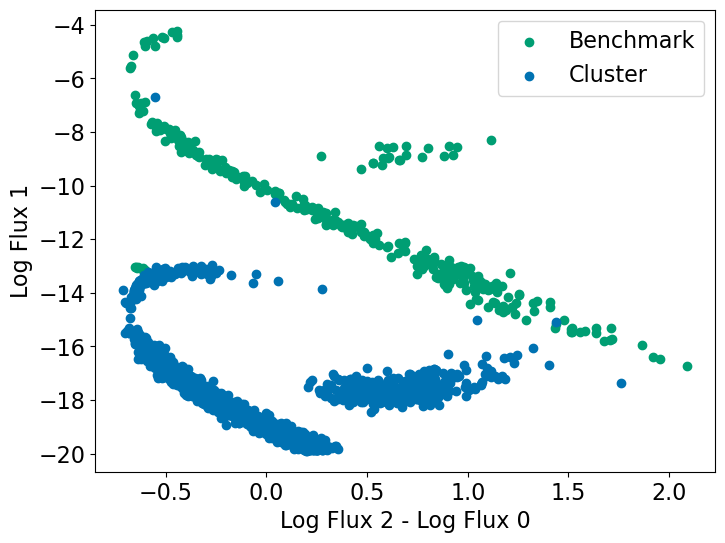

In [16]:
fig = plt.figure()
for j, point in enumerate(all_points):
    try:
        this = Table.read(point,format='ascii')

        thispar = this['Parallax']
        thism0, thism1, thism2 = (np.log10(this['BlueF']), 
                                  np.log10(this['GreenF']), 
                                  np.log10(this['RedF']))
        thiscolour = thism2-thism0
        dist = 1/thispar
        abs_mag = thism1 + 2*np.log10(dist)
        mm = thispar>0.05
        
        h = plt.scatter(thiscolour[mm],abs_mag[mm],color=colours[1])
    except:
        pass

s = plt.scatter(colour,m1,color=colours[0])

plt.ylabel('Log Flux 1')
plt.xlabel('Log Flux 2 - Log Flux 0')

plt.legend([h,s],['Benchmark','Cluster'])

So this cluster is much further away! By trial and error, let's find a distance modulus that looks right. 

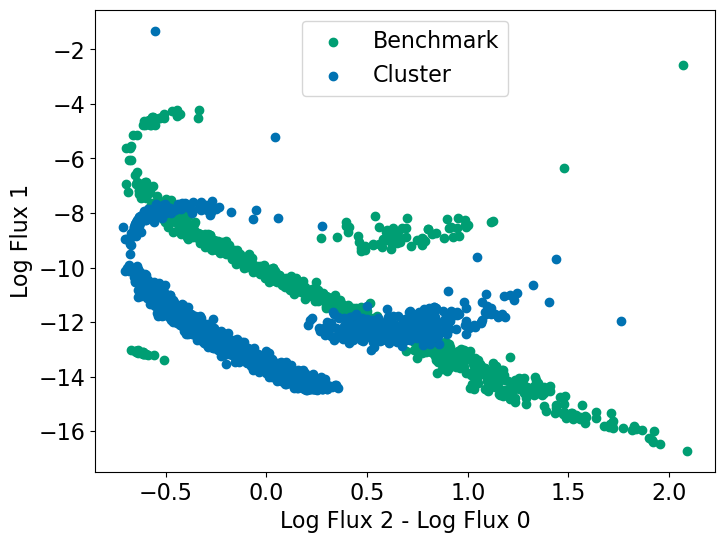

In [26]:
fig = plt.figure()
for j, point in enumerate(all_points):
    try:
        this = Table.read(point,format='ascii')

        thispar = this['Parallax']
        thism0, thism1, thism2 = (np.log10(this['BlueF']), 
                                  np.log10(this['GreenF']), 
                                  np.log10(this['RedF']) )
        thiscolour = thism2-thism0
        dist = 1/thispar
        abs_mag = thism1 + 2*np.log10(dist)
        mm = thispar>0.01
        
        h = plt.scatter(thiscolour[mm],abs_mag[mm],color=colours[1])
    except:
        pass

s = plt.scatter(colour,m1+5.4,color=colours[0])

plt.ylabel('Log Flux 1')
plt.xlabel('Log Flux 2 - Log Flux 0')

plt.legend([h,s],['Benchmark','Cluster'])

By trial and error it looks like this offset is about (5.4 to 5.5).

This is `2*log10(distance)` so this cluster is at a distance of 10^(2.7 - 2.75) = 500-560 pc. 

(I looked it up in the answers and it's 520 pc - so a pretty decent estimate!)

LET'S ESTIMATE THE DISTANCE TO A BUNCH OF CLUSTERS AHHHHHHHHHHHHHH

I will assume a cluster is just something with alot of points. this is stupid on my part but idk what else to do. ASK BEN.

In [30]:
all_clusters = []
for j, point in enumerate(all_points):
    try:
        this = Table.read(point, format="ascii")
        # GUYS DONT CHANGE 100 MY LAPTOP IS A POTATO
        if len(this) >= 100:
            all_clusters.append(point)
    except: 
        pass

print(all_clusters)

['universe_8\\Back\\Star_Data.csv', 'universe_8\\Bottom\\Star_Data.csv', 'universe_8\\Front\\Star_Data.csv', 'universe_8\\Left\\Star_Data.csv', 'universe_8\\Right\\Star_Data.csv', 'universe_8\\Top\\Star_Data.csv']


AttributeError: 'list' object has no attribute 'items'

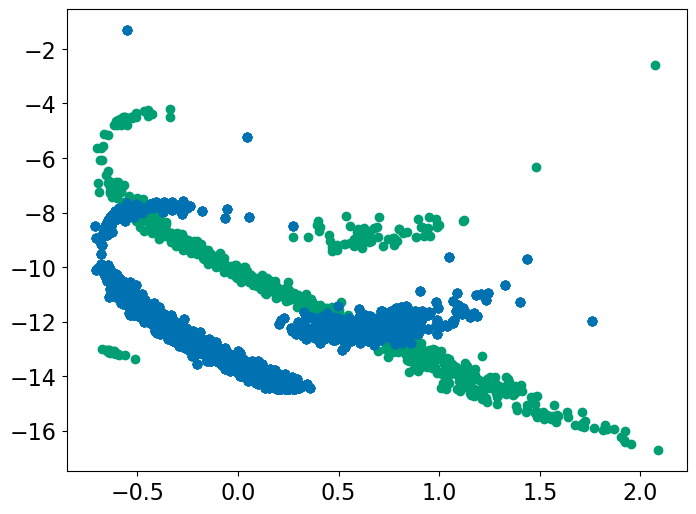

In [32]:
for j in range(len(all_clusters)): #Change this to the cluster you want to look at
    cluster = Table.read(all_clusters[j],format='ascii')
    newcluster = Table()
    
    #Some images have two clusters so select only the biggest one by eye
    if j == 4:
        counter = 0
        for star in cluster:
            if star['Y'] < 22 and star['X'] > 25:
                if counter == 0:
                    newcluster = Table(star)
                else:
                    newcluster.add_row(star)
                counter += 1
        cluster = newcluster
    elif j == 14:
        counter = 0
        for star in cluster:
            if star['Y'] > 24 and star['X'] > 8:
                if counter == 0:
                    newcluster = Table(star)
                else:
                    newcluster.add_row(star)
                counter += 1
        cluster = newcluster
    elif j == 16:
        counter = 0
        for star in cluster:
            if star['Y'] < 26 and star['X'] > -38:
                if counter == 0:
                    newcluster = Table(star)
                else:
                    newcluster.add_row(star)
                counter += 1
        cluster = newcluster
    else:
        pass
    
    cluster_mag = np.log10(cluster['GreenF']) #apparent magnitude of cluster
    cluster_colour = np.log10(cluster['RedF'])-np.log10(cluster['BlueF']) #colour of cluster

    good_stars_mag_median = np.median(good_stars['abs_mag']) #median absolute magnitude of the good stars
    cluster_mag_median = np.median(cluster_mag) #median absolute magnitude of the cluster

    diff_in_mag_median = good_stars_mag_median-cluster_mag_median #the difference

    #Set the limits for the histogram
    xmin = cluster_colour.min()
    xmax = cluster_colour.max()
    ymin = cluster_mag.min()
    ymax = good_stars['abs_mag'].max()
    
    #Specify the bin widths
    if j in [19]:
        ybinspace = 0.5
        xbinspace = 0.12
    elif j in [7, 27]:
        ybinspace = 0.7
        xbinspace = 0.12
    elif j in [5, 8, 15]:
        ybinspace = 0.8 #0.7, 0.9, 1.2
        xbinspace = 0.12
    elif j in [3, 17, 21]:
        ybinspace = 0.9 #0.7, 0.9, 1.2
        xbinspace = 0.12
    elif j in [6, 20]:
        ybinspace = 0.2
        xbinspace = 0.2
    elif j == 4:
        ybinspace = 0.6
        xbinspace = 0.12
    else:
        ybinspace = 0.75
        xbinspace = 0.12
    nxbins = np.rint((xmax-xmin)/xbinspace).astype(int)
    nybins = np.rint((ymax-ymin)/ybinspace).astype(int)
    binspace = [nxbins, nybins] 
    
    #Estimated fitted score (lower scores mean the overlap of the hr diagrams are better)
    estimate_with_score = np.zeros((72,2))
    
    #Calculate the overlap score
    good_stars_histogram = np.histogram2d(good_stars['colour'], good_stars['abs_mag'], bins=binspace, range = [[xmin, xmax], [ymin, ymax]])
    i = 0
    for estimate in np.arange(diff_in_mag_median-1.8, diff_in_mag_median+1.8, 0.05):
        cluster_histogram = np.histogram2d(cluster_colour, cluster_mag+estimate, bins=binspace, range = [[xmin, xmax], [ymin, ymax]])
        score = np.linalg.norm(cluster_histogram[0]-good_stars_histogram[0])
        estimate_with_score[i] = [estimate, score]
        i += 1
    cluster_diff_app_and_abs_mag = estimate_with_score[np.where(estimate_with_score == estimate_with_score[:,1].min())[0][0],0]
    cluster_distance = 10**(cluster_diff_app_and_abs_mag/2) #distance = 10**((abs_mag-thism1)/2)
    
    #Print information about cluster
    print('Cluster #: %.0f Score: %.3f Magnitude difference: %.3f Distance: %.0f kpc' % (j+1, score, \
                                        cluster_diff_app_and_abs_mag, cluster_distance))
    print('Difference in median magnitude: %.3f' % diff_in_mag_median)
    print('Cluster file name: ' + possible_clusters[j])
    
    #hr diagram of cluster on top of that of the good stars
    s = plt.scatter(cluster_colour,cluster_mag+cluster_diff_app_and_abs_mag,color='blue') #Colour vs apparent brightness
    h = plt.scatter(good_stars['colour'],good_stars['abs_mag'],color='red')
    plt.ylabel('Log Flux 1')
    plt.xlabel('Log Flux 2 - Log Flux 0')
    plt.show()
    
    #Plot of the cluster
    plt.scatter(cluster['x'],cluster['y'])
    plt.xlabel('x (pix)')
    plt.ylabel('y (pix)');
    plt.show()